In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
from pandas.plotting import autocorrelation_plot
from math import sqrt
import researchpy as rp
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import random as ran
from pprint import pprint

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn import datasets
from sklearn import set_config
set_config(display='diagram')
from xgboost import XGBClassifier, XGBRegressor
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
#from textacy.preprocess import preprocess_text

from gensim import corpora, models, matutils
from collections import defaultdict, Counter

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf

import patsy
from itertools import combinations

import graphviz
import json
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from time import sleep
import re
import twitter

In [2]:
%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Build and document a working model, prototype, recommendation, or solution

Note: The new Statcast metrics are available beginning from the 2015 baseball season to the current season. I downloaded the 2015-2017 baseball season data for all teams which will be used in the data modeling.

## [pybaseball](https://github.com/jldbc/pybaseball) 
Pull current and historical baseball statistics using Python (Statcast, Baseball Reference, FanGraphs)

`pybaseball` is a Python package for baseball data analysis. This package scrapes Baseball Reference, Baseball Savant, and FanGraphs so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods. See the [docs](https://github.com/jldbc/pybaseball/tree/master/docs) for a comprehensive list of data acquisition functions.

**Statcast**

The statcast function retrieves pitch-level statcast data for a given date or range or dates.

statcast(start_dt=[yesterday's date], end_dt=None, team=None)

In [3]:
# Pull advanced metrics from Major League Baseball's Statcast system
#from pybaseball import statcast

# Look up a player's MLBAM, Retrosheet, FanGraphs, and Baseball Reference ID by name
#from pybaseball import playerid_lookup

### Reading a File

In [4]:
# Create data path variable for loading data
data_path = '/Users/yangweichle/Documents/Employment/TRAINING/DATA SCIENCE/PROJECTS/PredictingBaseballStatistics/Datasets/'

In [5]:
# Read file into DataFrame
# Note: header=0 disables the header from the file
all_MLB_teams2015_2017 = pd.read_csv(data_path + 'all_MLB_teams2015_2017.csv', header=0) # Comma-separated values file

### Examine the DataFrame

In [6]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017.shape[0], all_MLB_teams2015_2017.shape[1]))

Rows: 2139920, Cols: 91


In [7]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist
#       show_counts: whether to show the non-null counts
all_MLB_teams2015_2017.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139920 entries, 0 to 2139919
Data columns (total 91 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Unnamed: 0                       2139920 non-null  int64  
 1   index                            2139920 non-null  int64  
 2   pitch_type                       2136106 non-null  object 
 3   game_date                        2139920 non-null  object 
 4   release_speed                    2137415 non-null  float64
 5   release_pos_x                    2118565 non-null  float64
 6   release_pos_z                    2118565 non-null  float64
 7   player_name                      2139920 non-null  object 
 8   batter                           2139920 non-null  float64
 9   pitcher                          2139920 non-null  float64
 10  events                           553868 non-null   object 
 11  description                      2139920 non-null 

In [8]:
# Column names (which is "an index")
all_MLB_teams2015_2017.columns

Index(['Unnamed: 0', 'index', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pos1_person_id',
       'pos2_person_id.1', 'pos3_person_id', 'pos4_person_id',
       'pos5_person_id', 'pos6_person_id', 'pos7_person

In [9]:
# Sort a DataFrame by multiple columns
# Note: ascending: sort ascending vs. descending; ascending=True is default
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True)

In [10]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_MLB_teams2015_2017.head().append(all_MLB_teams2015_2017.tail())

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2139919,702491,17584,FF,2015-04-05,93.6,2.552,5.5293,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139918,702490,17583,FF,2015-04-05,93.4,2.5694,5.6476,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139917,702489,17582,FF,2015-04-05,94.8,2.6266,5.2936,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139916,702488,17581,FF,2015-04-05,91.6,NaN,NaN,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139915,702487,17580,CU,2015-04-05,75.9,NaN,NaN,Jon Lester,"572,761.0","452,657.0",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,4,650,FT,2017-10-01,95.9,-0.8903,6.1341,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
3,3,636,CH,2017-10-01,82.8,-0.9901,6.0626,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
2,2,620,FF,2017-10-01,94.7,-0.6208,6.3387,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
1,1,615,FC,2017-10-01,91.8,-1.0777,6.1772,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
0,0,597,FC,2017-10-01,91.9,-1.1948,5.9921,Roberto Osuna,"595,885.0","532,077.0",...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN


#### Identifying important columns to include in the DataFrame.

In [11]:
# Select multiple columns
# Note: release_speed = Pitch Velocity (MPH)
#       bb_type = Batted Ball Type
#       launch_speed = Exit Velocity (MPH)
#       launch_angle = Launch Angle (Degrees)
baseball_cols = ['game_date', 'home_team', 'away_team', 'player_name', 'pitcher', 'pitch_type', 'pitch_name', 'release_speed',
                 'batter', 'events', 'description', 'bb_type', 'des', 'launch_speed', 'launch_angle', 'hit_distance_sc'] 
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017[baseball_cols]

In [12]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 2139920, Cols: 16


In [13]:
# Print the first 5 rows of the DataFrame
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,release_speed,batter,events,description,bb_type,des,launch_speed,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.6,"572,761.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.4,"572,761.0",NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,94.8,"572,761.0",NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,91.6,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,75.9,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN


In [14]:
# Rename one or more columns in the original DataFrame rather than returning a new view
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.rename(columns={'release_speed': 'pitch_velocity',
                                                                        'bb_type': 'batted_ball_type',
                                                                        'launch_speed': 'exit_velocity'})

In [15]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist
#       show_counts: whether to show the non-null counts
all_MLB_teams2015_2017_new.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139920 entries, 2139919 to 0
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   game_date         2139920 non-null  object 
 1   home_team         2139920 non-null  object 
 2   away_team         2139920 non-null  object 
 3   player_name       2139920 non-null  object 
 4   pitcher           2139920 non-null  float64
 5   pitch_type        2136106 non-null  object 
 6   pitch_name        2136106 non-null  object 
 7   pitch_velocity    2137415 non-null  float64
 8   batter            2139920 non-null  float64
 9   events            553868 non-null   object 
 10  description       2139920 non-null  object 
 11  batted_ball_type  386941 non-null   object 
 12  des               553866 non-null   object 
 13  exit_velocity     554876 non-null   float64
 14  launch_angle      554901 non-null   float64
 15  hit_distance_sc   508478 non-null   float64
dtype

### Examine Missing Values

In [16]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
pitch_type,3814,0.18
pitch_name,3814,0.18
pitch_velocity,2505,0.12
events,1586052,74.12
batted_ball_type,1752979,81.92
des,1586054,74.12
exit_velocity,1585044,74.07
launch_angle,1585019,74.07
hit_distance_sc,1631442,76.24


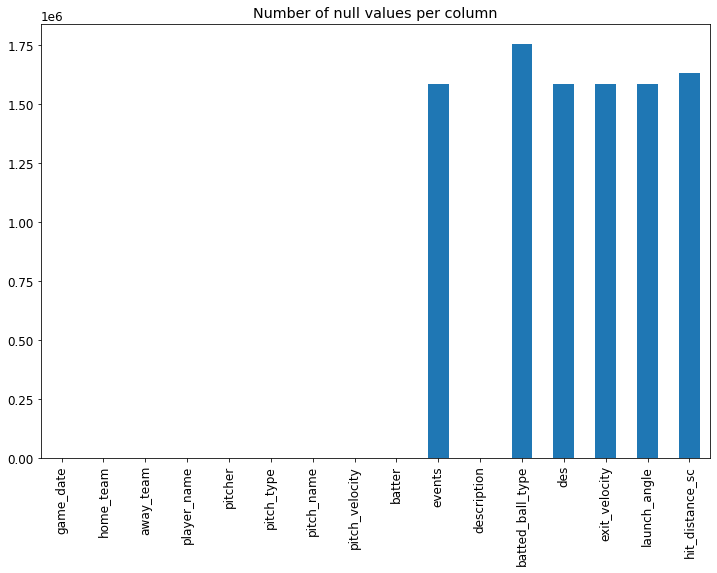

In [17]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar();
plt.title('Number of null values per column');

#### Approach for excluding records:

Each record represents an interaction between a pitcher and a batter (i.e., a pitch thrown by the pitcher to the batter).  The goal is to keep any interaction for which Statcast could provide valid measurements for the metrics `launch_speed`, `launch_angle`, and `hit_distance_sc`.

In order to do so, non-batted ball records will be excluded. <br>

- Drop all `events` = NaN which represent interactions where the batter did not make contact with the ball or the batter made contact with the ball but it was hit foul (e.g., ball, foul, called strike, swinging strike, blocked ball, foul tip, intentional ball, foul bunt, swinging strike blocked, missed bunt, pitchout)

- Drop all `batted_ball_type` = NaN which represents other remaining events where there was not a batted ball (e.g., strikeout, walk, hit by pitch, intentional walk, caught stealing, etc.)

#### Examine `events` column for missingness.

In [18]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
def value_counts_func(df, var, bar, title=''):
    value_counts = df[var].value_counts(dropna=False)
    value_percents = round(df[var].value_counts(normalize=True, dropna=False)*100, 2)
    df_ = pd.DataFrame({'counts': value_counts, 'percentage': value_percents}).rename_axis(var).reset_index()
    
    if bar:
        # Create a vertical bar plot
        # Note: figsize: a tuple (width, height) in inches
        #       rot: rotation for ticks (xticks for vertical, yticks for horizontal plots)
        percents = df[var].value_counts(normalize=True, dropna=False)*100
        ax = percents.plot(kind='bar', figsize=(10, 6), rot=0);
        ax.set_title(title);
        ax.set_ylabel('Percentage');

    format_dict = {'percentage': '{:.2f}'}
    return df_.style.format(format_dict).hide_index()

In [19]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'events', bar=False)

events,counts,percentage
nan,1586052,74.12
field_out,223381,10.44
strikeout,116120,5.43
single,82491,3.85
walk,42138,1.97
double,24898,1.16
home_run,16629,0.78
force_out,11500,0.54
grounded_into_double_play,11266,0.53
hit_by_pitch,5019,0.23


In [20]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.events.isna() # alias of isnull()
null_events = all_MLB_teams2015_2017_new.events.isnull()
all_MLB_teams2015_2017_new[null_events]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.6,"572,761.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.4,"572,761.0",NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,94.8,"572,761.0",NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,91.6,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,75.9,"572,761.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FF,4-Seam Fastball,96.0,"595,885.0",NaN,called_strike,NaN,NaN,NaN,NaN,NaN
4,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FT,2-Seam Fastball,95.9,"595,885.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
3,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",CH,Changeup,82.8,"595,885.0",NaN,ball,NaN,NaN,NaN,NaN,NaN
2,2017-10-01,NYY,TOR,Roberto Osuna,"532,077.0",FF,4-Seam Fastball,94.7,"595,885.0",NaN,ball,NaN,NaN,75.0,-7.6433,20.0


#### What types of interactions occurred for missing `events`?

In [21]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new[null_events], 'description', bar=False)

description,counts,percentage
ball,676751,42.67
foul,371731,23.44
called_strike,333190,21.01
swinging_strike,131229,8.27
blocked_ball,45367,2.86
foul_tip,10704,0.67
foul_bunt,6228,0.39
intent_ball,4724,0.30
swinging_strike_blocked,4312,0.27
missed_bunt,1299,0.08


#### Drop missing values from `events` column.

In [22]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['events'], inplace=True)

#### Examine `batted_ball_type` column for missingness.

batted_ball_type,counts,percentage
ground_ball,178646,32.25
nan,166927,30.14
line_drive,99714,18.00
fly_ball,81752,14.76
popup,26829,4.84


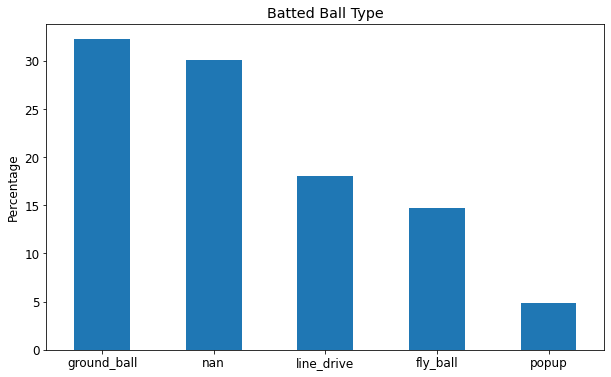

In [23]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'batted_ball_type', bar=True, title='Batted Ball Type')

In [24]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.batted_ball_type.isna() # alias of isnull()
null_batted_ball_type = all_MLB_teams2015_2017_new.batted_ball_type.isnull()
all_MLB_teams2015_2017_new[null_batted_ball_type]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139906,2015-04-05,CHC,STL,Jon Lester,"452,657.0",CU,Curveball,76.8,"425,509.0",strikeout,swinging_strike,NaN,Jhonny Peralta strikes out swinging.,NaN,NaN,NaN
2139901,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FC,Cutter,89.9,"571,431.0",strikeout,swinging_strike,NaN,Matt Adams strikes out swinging.,NaN,NaN,NaN
2139890,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,84.9,"519,203.0",strikeout,called_strike,NaN,Anthony Rizzo called out on strikes.,NaN,NaN,NaN
2139882,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,92.0,"425,877.0",strikeout,swinging_strike,NaN,Yadier Molina strikes out swinging.,NaN,NaN,NaN
2139875,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,89.6,"543,939.0",walk,ball,NaN,Kolten Wong walks.,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,2017-10-01,NYY,TOR,Domingo German,"593,334.0",FF,4-Seam Fastball,97.0,"606,192.0",strikeout,swinging_strike,NaN,Teoscar Hernandez strikes out swinging.,NaN,NaN,NaN
44,2017-10-01,NYY,TOR,Ryan Tepera,"572,193.0",FC,Cutter,88.9,"592,122.0",strikeout,swinging_strike,NaN,Tyler Austin strikes out swinging.,NaN,NaN,NaN
38,2017-10-01,NYY,TOR,Ryan Tepera,"572,193.0",FC,Cutter,89.5,"543,305.0",strikeout,swinging_strike,NaN,Aaron Hicks strikes out swinging.,NaN,NaN,NaN
29,2017-10-01,NYY,TOR,Ben Heller,"621,294.0",CU,Curveball,82.8,"620,446.0",strikeout,swinging_strike,NaN,Richard Urena strikes out swinging.,NaN,NaN,NaN


#### What types of `events` occurred for missing `batted_ball_type`?

In [25]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new[null_batted_ball_type], 'events', bar=False)

events,counts,percentage
strikeout,116120,69.56
walk,42138,25.24
hit_by_pitch,5019,3.01
intent_walk,1884,1.13
caught_stealing_2b,696,0.42
strikeout_double_play,435,0.26
pickoff_caught_stealing_2b,131,0.08
other_out,120,0.07
catcher_interf,113,0.07
pickoff_1b,95,0.06


#### Drop missing values from `batted_ball_type` column.

In [26]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['batted_ball_type'], inplace=True)

#### Confirm whether the values for `events` and `batted_ball_type` are valid (i.e., values could provide valid measurements for Statcast metrics).

In [27]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'events', bar=False)

events,counts,percentage
field_out,223381,57.73
single,82491,21.32
double,24898,6.43
home_run,16629,4.30
force_out,11500,2.97
grounded_into_double_play,11266,2.91
field_error,4816,1.24
sac_fly,3549,0.92
sac_bunt,3149,0.81
triple,2607,0.67


batted_ball_type,counts,percentage
ground_ball,178646,46.17
line_drive,99714,25.77
fly_ball,81752,21.13
popup,26829,6.93


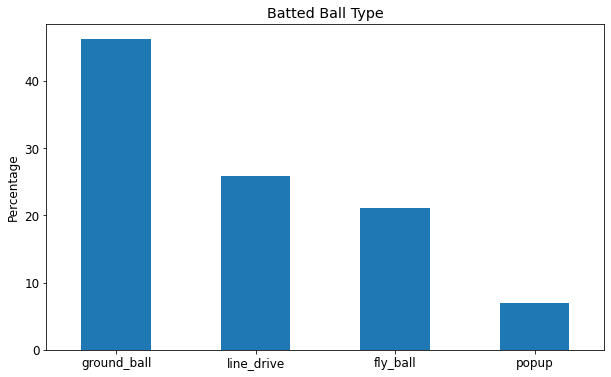

In [28]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'batted_ball_type', bar=True, title='Batted Ball Type')

In [29]:
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False).sum()

386941

In [30]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.events.fillna(' NaN'), all_MLB_teams2015_2017_new.batted_ball_type.fillna(' NaN'), margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

batted_ball_type,fly_ball,ground_ball,line_drive,popup,Total
events,,,,,
double,3502,3342,17914,140,24898
double_play,222,109,930,87,1348
field_error,159,4349,199,109,4816
field_out,60230,103445,33726,25980,223381
fielders_choice,0,301,0,0,301
fielders_choice_out,0,914,2,3,919
force_out,47,11342,74,37,11500
grounded_into_double_play,0,11266,0,0,11266
home_run,11547,0,5082,0,16629


Note: The above frequencies confirm valid values.

In [31]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
pitch_type,701,0.18
pitch_name,701,0.18
pitch_velocity,459,0.12
des,2,0.0
exit_velocity,66,0.02
launch_angle,66,0.02
hit_distance_sc,46472,12.01


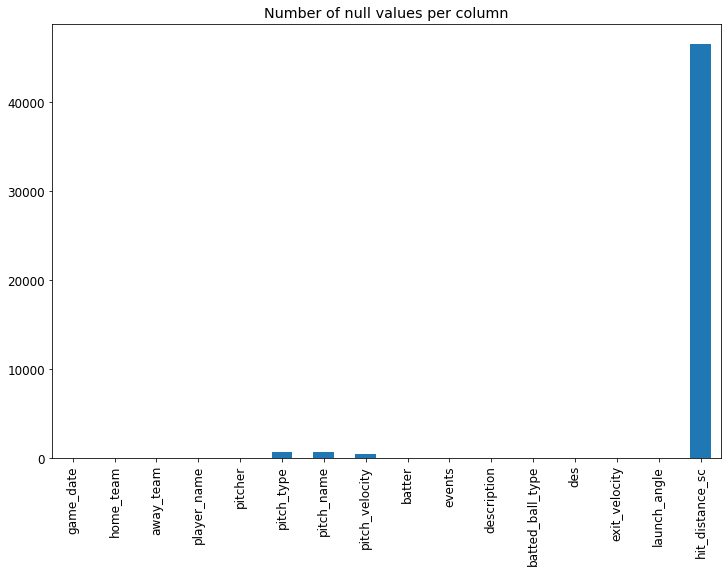

In [32]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar();
plt.title('Number of null values per column');

Note: There are still missing values for the following variables: `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle`. These variables will be used in the modeling and observations with missing values will be dropped.

#### Drop missing values from `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle` columns.

In [33]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['pitch_name', 'pitch_velocity', 'exit_velocity', 'launch_angle'], inplace=True)

### Summarize the DataFrame

In [34]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).describe()

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
count,"386,112.0","386,112.0","386,112.0","340,221.0"
mean,88.93805243038103,87.22838710008553,10.662181007583529,170.44668024607535
std,5.809725964258756,14.532314679064466,27.245970801318958,136.70036724975247
min,41.5,5.2,-88.89,0.0
25%,85.1,80.0,-8.987,22.0
50%,90.3,89.3,10.605,169.0
75%,93.3,98.1,28.520775,294.0
max,105.4,123.4,89.85,504.0


In [35]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['home_team', 'away_team', 'player_name', 'des'], axis=1).describe(include='object')

,game_date,pitch_type,pitch_name,events,description,batted_ball_type
count,386112,386112,386112,386112,386112,386112
unique,537,16,16,16,4,4
top,2015-09-30,FF,4-Seam Fastball,field_out,hit_into_play,ground_ball
freq,974,131254,131254,222928,249245,178259


In [36]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.pitch_name.fillna(' NaN'), all_MLB_teams2015_2017_new.pitch_type.fillna(' NaN'), margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

pitch_type,CH,CU,EP,FA,FC,FF,FO,FS,FT,KC,KN,PO,SC,SI,SL,UN,Total
pitch_name,,,,,,,,,,,,,,,,,
2-Seam Fastball,0,0,0,0,0,0,0,0,59444,0,0,0,0,0,0,0,59444
4-Seam Fastball,0,0,0,0,0,131254,0,0,0,0,0,0,0,0,0,0,131254
Changeup,43883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43883
Curveball,0,26046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26046
Cutter,0,0,0,0,21484,0,0,0,0,0,0,0,0,0,0,0,21484
Eephus,0,0,114,0,0,0,0,0,0,0,0,0,0,0,0,0,114
Fastball,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3
Forkball,0,0,0,0,0,0,126,0,0,0,0,0,0,0,0,0,126
Knuckle Ball,0,0,0,0,0,0,0,0,0,0,2094,0,0,0,0,0,2094


#### Drop low frequency `pitch_name` observations

In [37]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['pitch_name_low_freq'] = np.where(all_MLB_teams2015_2017_new.pitch_name.isin(['Eephus', 'Fastball', 'Forkball', 'Pitch Out', 'Screwball', 'Unknown']), 1, 0)

pitch_name_low_freq,counts,percentage
0,385848,99.93
1,264,0.07


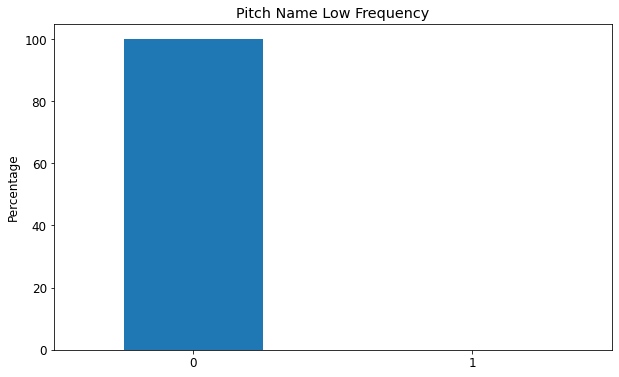

In [38]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'pitch_name_low_freq', bar=True, title='Pitch Name Low Frequency')

In [39]:
# Excluding low frequency values
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new[all_MLB_teams2015_2017_new.pitch_name_low_freq == 0]
all_MLB_teams2015_2017_new.drop('pitch_name_low_freq', axis=1, inplace=True)

In [40]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 385848, Cols: 16


#### Create indicator for whether an event was a Home Run (HR)

In [41]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'events', bar=False)

events,counts,percentage
field_out,222774,57.74
single,82232,21.31
double,24838,6.44
home_run,16587,4.30
force_out,11474,2.97
grounded_into_double_play,11234,2.91
field_error,4806,1.25
sac_fly,3539,0.92
sac_bunt,3117,0.81
triple,2599,0.67


In [42]:
# Lambda function: apply an arbitrary function to each value of a Pandas column, storing the result in a new column
all_MLB_teams2015_2017_new['hr'] = all_MLB_teams2015_2017_new.events.apply(lambda events: 1 if events == 'home_run' else 0)

hr,counts,percentage
0,369261,95.70
1,16587,4.30


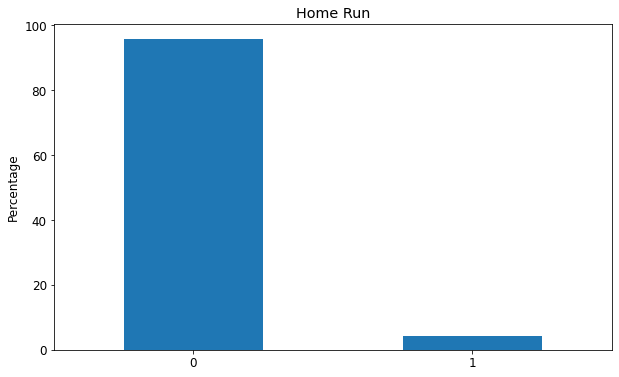

In [43]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'hr', bar=True, title='Home Run')

#### Create indicator for whether an event was an Extra-base Hit (XBH)

In [44]:
# Check whether `values` are contained in Series
# all_MLB_teams2015_2017_new['xbh_bool'] = all_MLB_teams2015_2017_new.events.isin(['double', 'triple', 'home_run'])

In [45]:
# Map values of Series using input correspondence (i.e., map existing input values to new outputs values)
# all_MLB_teams2015_2017_new['xbh'] = all_MLB_teams2015_2017_new.xbh_bool.map({False:0, True:1})
# all_MLB_teams2015_2017_new.drop('xbh_bool', axis=1, inplace=True)

In [46]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['xbh'] = np.where(all_MLB_teams2015_2017_new.events.isin(['double', 'triple', 'home_run']), 1, 0)

xbh,counts,percentage
0,341824,88.59
1,44024,11.41


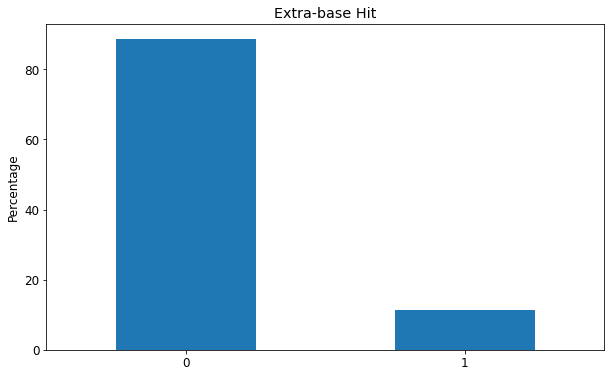

In [47]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'xbh', bar=True, title='Extra-base Hit')

In [48]:
# Calculate the correlation matrix using the default method (Pearson correlation)
baseball_correlations = all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).corr(method='pearson')
round(baseball_correlations, 3)

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc,hr,xbh
pitch_velocity,1.0,0.079,0.007,0.017,-0.007,-0.003
exit_velocity,0.079,1.0,0.187,0.352,0.233,0.303
launch_angle,0.007,0.187,1.0,0.733,0.135,0.134
hit_distance_sc,0.017,0.352,0.733,1.0,0.375,0.417
hr,-0.007,0.233,0.135,0.375,1.0,0.591
xbh,-0.003,0.303,0.134,0.417,0.591,1.0


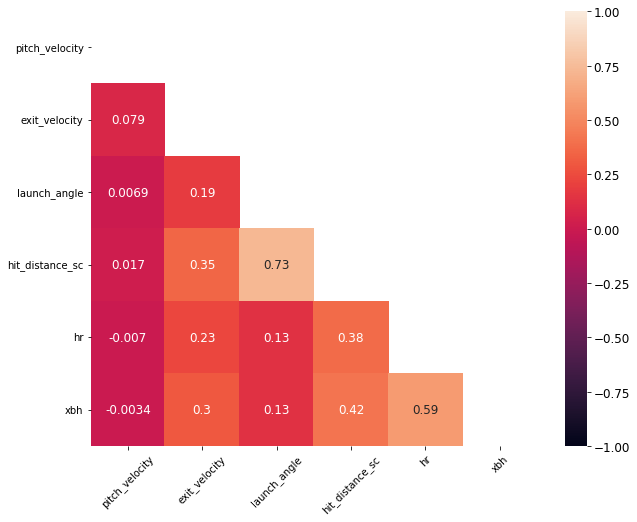

In [49]:
# Create a figure and a set of subplots
# Note: figsize: a tuple (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 8));

# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(baseball_correlations, dtype=np.bool)
# Return the indices for the upper-triangle of array
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix (color-encoded) using Seaborn's .heatmap() function
# Note: vmin, vmax: values to anchor the colormap, otherwise they are inferred from the data & other keyword arguments
#       annot: write the data value in each cell
ax = sns.heatmap(baseball_correlations, vmin=-1, vmax=1, annot=True, mask=mask, ax=ax);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, rotation=45);
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va='center', rotation=0);

plt.show();

#### Examine Exit Velocity by HR Groups

In [50]:
# For each group, describe var:
def groupby_describe_func(df, byvar, var, sortvar=''):
    return round(df.groupby(by=byvar)[var].describe().sort_values(by=[sortvar], ascending=False), 3)

In [51]:
# For each group, describe var:
groupby_describe_func(df=all_MLB_teams2015_2017_new, byvar='hr', 
                      var='exit_velocity', sortvar='mean')

,count,mean,std,min,25%,50%,75%,max
hr,,,,,,,,
1,"16,587.0",103.234,4.414,36.6,100.5,103.3,106.2,121.1
0,"369,261.0",86.512,14.415,5.2,80.0,88.6,97.1,123.4


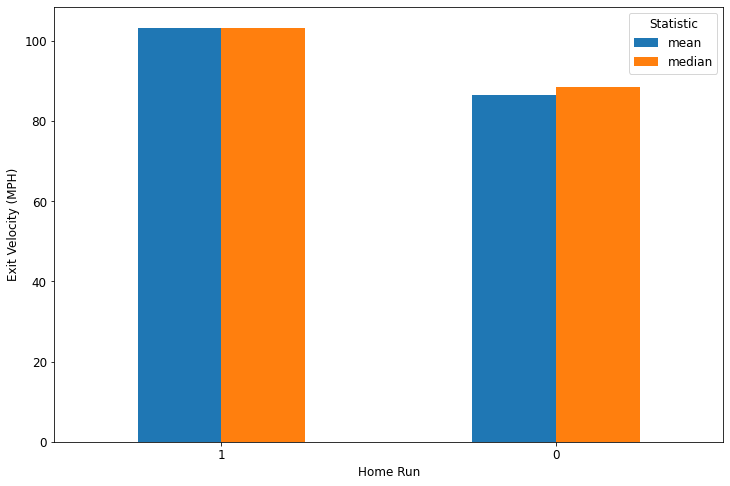

In [52]:
groupby_describe_func(df=all_MLB_teams2015_2017_new, byvar='hr', 
                      var='exit_velocity', sortvar='mean')[['mean', '50%']].head(10).plot(kind='bar');
plt.xticks(rotation='horizontal');
plt.xlabel('Home Run');
plt.ylabel('Exit Velocity (MPH)');
plt.legend(title='Statistic', labels=('mean', 'median'), loc='upper right');

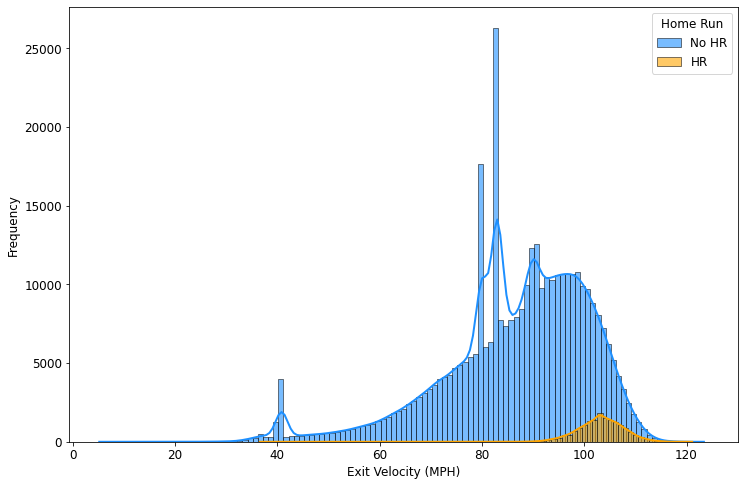

In [53]:
x1 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.exit_velocity.notnull())].loc[all_MLB_teams2015_2017_new.hr==0, 'exit_velocity']
x2 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.exit_velocity.notnull())].loc[all_MLB_teams2015_2017_new.hr==1, 'exit_velocity']

# Plot
kwargs = dict(line_kws={'linewidth': 2})

sns.histplot(x1,
             stat='frequency', # 'frequency' equivalent to 'count' when binwidth=1
             binwidth=1,
             #discrete=True,
             kde=True,
             color='dodgerblue',
             alpha=.6,
             label='No HR',
             **kwargs)
sns.histplot(x2,
             stat='frequency', # 'frequency' equivalent to 'count' when binwidth=1
             binwidth=1,
             #discrete=True,
             kde=True,
             color='orange',
             alpha=.6,
             label='HR',
             **kwargs)
#plt.xlim(left, right)
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Frequency')
plt.legend(title='Home Run', loc='upper right');

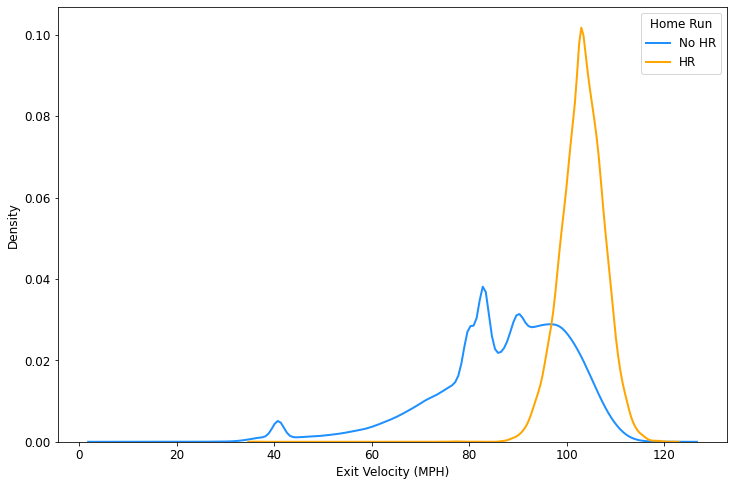

In [54]:
x1 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.exit_velocity.notnull())].loc[all_MLB_teams2015_2017_new.hr==0, 'exit_velocity']
x2 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.exit_velocity.notnull())].loc[all_MLB_teams2015_2017_new.hr==1, 'exit_velocity']

# Plot
sns.kdeplot(x1,
            color='dodgerblue',
            linewidth=2,
            label='No HR')
sns.kdeplot(x2,
            color='orange',
            linewidth=2,
            label='HR')
#plt.xlim(left, right)
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Density')
plt.legend(title='Home Run', loc='upper right');

[Normality Tests](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)
- QQ Plot
- Shapiro-Wilk test

hr   
0   0    Figure(864x576)
1   0    Figure(864x576)
Name: exit_velocity, dtype: object

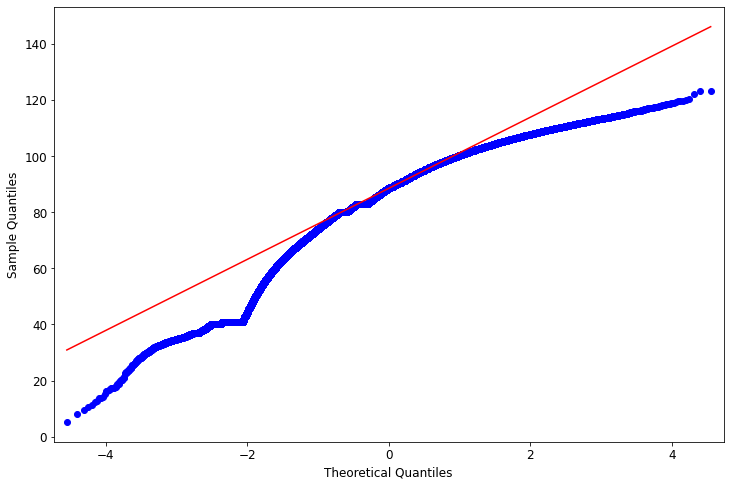

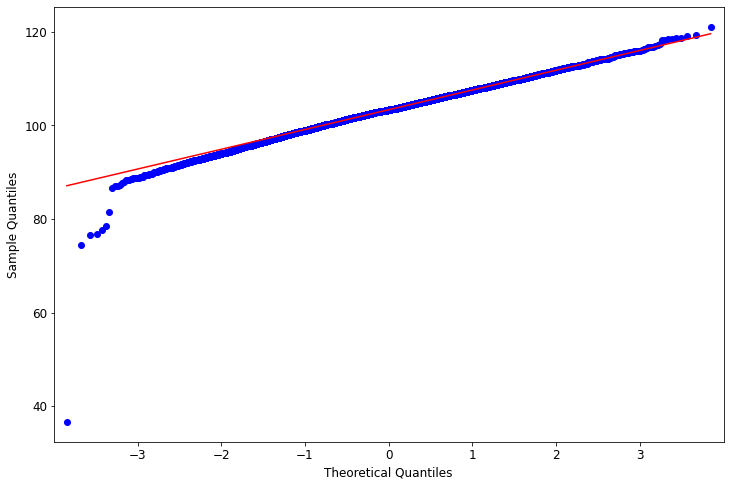

In [55]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution
# Note: dist: comparison distribution; the default is scipy.stats.distributions.norm (a standard normal)
#       line: options for the reference line to which the data is compared;
#             "45" - 45-degree line
#             "s" - standardized line, the expected order statistics are scaled by the standard deviation of the given sample and have the mean added to them
#             "r" - A regression line is fit
#             "q" - A line is fit through the quartile
all_MLB_teams2015_2017_new.groupby(by='hr').exit_velocity.apply(lambda x: pd.Series(sm.qqplot(x, line='q')))
#plt.show()

In [56]:
# Perform the Shapiro-Wilk test for normality
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
# Note: p-value may not be accurate for N > 5000
sw_df = round(all_MLB_teams2015_2017_new.groupby(by='hr').exit_velocity \
        .apply(lambda x: pd.Series(stats.shapiro(x.dropna()), index=['W-statistic', 'p-value'])), 3)
print('Shapiro-Wilk test:')
print('H0: the sample has a Normal distribution \nHa: the sample does not have a Normal distribution\n')
print(sw_df)

Shapiro-Wilk test:
H0: the sample has a Normal distribution 
Ha: the sample does not have a Normal distribution

hr             
0   W-statistic    0.94
    p-value         0.0
1   W-statistic   0.989
    p-value         0.0
Name: exit_velocity, dtype: float64


/Users/yangweichle/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[Mann-Whitney U test](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

In [57]:
# Compute the Mann-Whitney rank test on samples x and y
# Use only when the number of observation in each sample is > 20 and you have 2 independent samples of ranks
# This test corrects for ties and by default uses a continuity correction
# Note: alternative: defines the alternative hypothesis;
#                    'two-sided', 'less': one-sided, 'greater': one-sided
statistic, pvalue = stats.mannwhitneyu(*all_MLB_teams2015_2017_new.groupby(by='hr').exit_velocity.apply(lambda x: list(x)),
                                       alternative='two-sided')
print('Mann-Whitney U test:')
print('U-statistic =', round(statistic, 3))
print('p-value     =', round(pvalue, 3))

Mann-Whitney U test:
U-statistic = 665538226.5
p-value     = 0.0


[Independent Two-Sample T-test](https://pythonfordatascience.org/independent-t-test-python/)

In [58]:
# Calculate the T-test for the means of *two independent* samples of scores
# Note: equal_var: if True (default), perform a standard independent 2 sample test that assumes equal population variances;
#                  if False, perform Welch's t-test, which does not assume equal population variance
#       nan_policy: defines how to handle when input contains nan. 'propagate' returns nan, 'raise' throws an error,
#                   'omit' performs the calculations ignoring nan values; default is 'propagate'
statistic, pvalue = stats.ttest_ind(*all_MLB_teams2015_2017_new.groupby(by='hr').exit_velocity.apply(lambda x: list(x)),
                                    equal_var=True, nan_policy='omit')
print('Independent Two-Sample t-test:')
print('t-statistic =', round(statistic, 3))
print('p-value     =', round(pvalue, 3))

Independent Two-Sample t-test:
t-statistic = -149.094
p-value     = 0.0


In [59]:
a = all_MLB_teams2015_2017_new.groupby(by='hr').exit_velocity.apply(lambda x: list(x))
a0 = pd.Series(a[0])
a1 = pd.Series(a[1])
descriptives, results = rp.ttest(a0, a1, 'No HR', 'HR')
round(descriptives, 3)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,No HR,"369,261.0",86.512,14.415,0.024,86.465,86.558
1,HR,"16,587.0",103.234,4.414,0.034,103.167,103.301
2,combined,"385,848.0",87.231,14.532,0.023,87.185,87.277


In [60]:
round(results, 3)

,Independent t-test,results
0,Difference (No HR - HR) =,-16.722
1,Degrees of freedom =,"385,846.0"
2,t =,-149.094
3,Two side test p value =,0.0
4,Difference < 0 p value =,0.0
5,Difference > 0 p value =,1.0
6,Cohen's d =,-1.183
7,Hedge's g =,-1.183
8,Glass's delta =,-1.16
9,r =,0.233


#### Examine Launch Angle by HR Groups

In [61]:
# For each group, describe var:
groupby_describe_func(df=all_MLB_teams2015_2017_new, byvar='hr', 
                      var='launch_angle', sortvar='mean')

,count,mean,std,min,25%,50%,75%,max
hr,,,,,,,,
1,"16,587.0",27.998,5.258,-47.842,24.156,27.65,31.358,49.741
0,"369,261.0",9.884,27.575,-88.89,-10.133,9.102,27.608,89.85


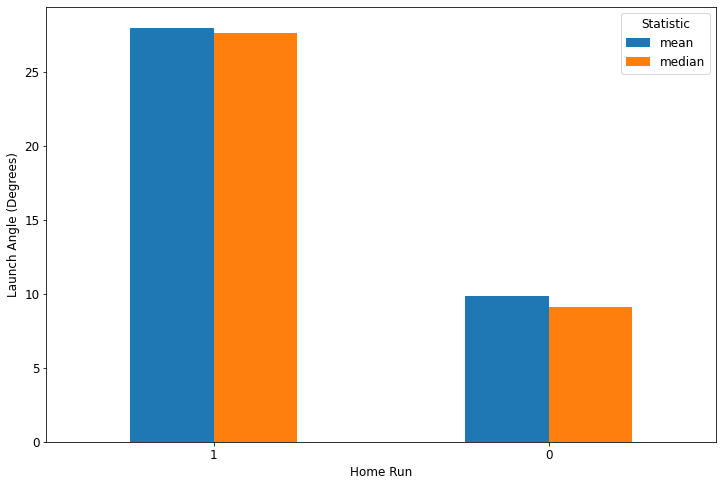

In [62]:
groupby_describe_func(df=all_MLB_teams2015_2017_new, byvar='hr', 
                      var='launch_angle', sortvar='mean')[['mean', '50%']].head(10).plot(kind='bar');
plt.xticks(rotation='horizontal');
plt.xlabel('Home Run');
plt.ylabel('Launch Angle (Degrees)');
plt.legend(title='Statistic', labels=('mean', 'median'), loc='upper right');

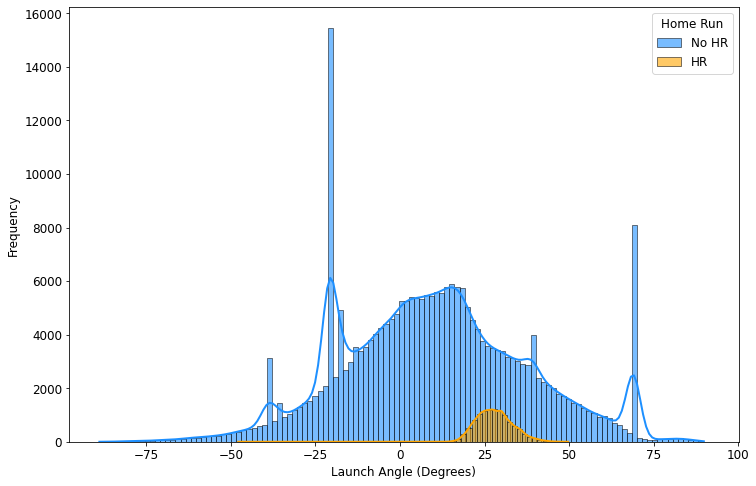

In [63]:
x1 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.launch_angle.notnull())].loc[all_MLB_teams2015_2017_new.hr==0, 'launch_angle']
x2 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.launch_angle.notnull())].loc[all_MLB_teams2015_2017_new.hr==1, 'launch_angle']

# Plot
kwargs = dict(line_kws={'linewidth': 2})

sns.histplot(x1,
             stat='frequency', # 'frequency' equivalent to 'count' when binwidth=1
             binwidth=1.5,
             #discrete=True,
             kde=True,
             color='dodgerblue',
             alpha=.6,
             label='No HR',
             **kwargs)
sns.histplot(x2,
             stat='frequency', # 'frequency' equivalent to 'count' when binwidth=1
             binwidth=1.5,
             #discrete=True,
             kde=True,
             color='orange',
             alpha=.6,
             label='HR',
             **kwargs)
#plt.xlim(left, right)
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Frequency')
plt.legend(title='Home Run', loc='upper right');

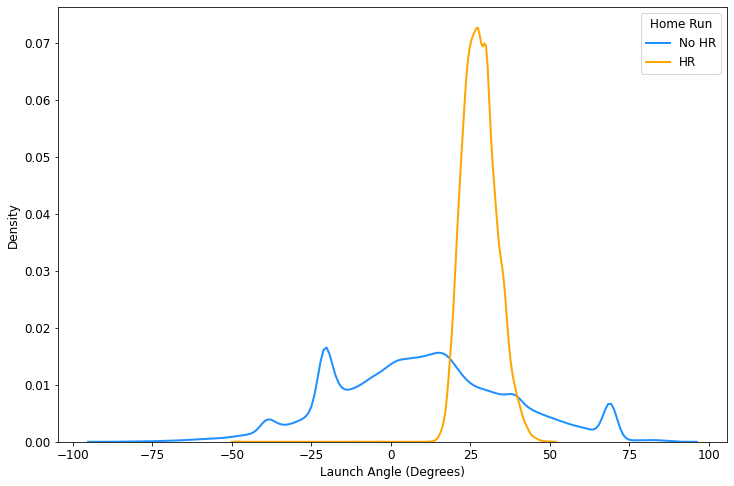

In [64]:
x1 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.launch_angle.notnull())].loc[all_MLB_teams2015_2017_new.hr==0, 'launch_angle']
x2 = all_MLB_teams2015_2017_new[(all_MLB_teams2015_2017_new.launch_angle.notnull())].loc[all_MLB_teams2015_2017_new.hr==1, 'launch_angle']

# Plot
sns.kdeplot(x1,
            color='dodgerblue',
            linewidth=2,
            label='No HR')
sns.kdeplot(x2,
            color='orange',
            linewidth=2,
            label='HR')
#plt.xlim(left, right)
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Density')
plt.legend(title='Home Run', loc='upper right');

[Normality Tests](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)
- QQ Plot
- Shapiro-Wilk test

hr   
0   0    Figure(864x576)
1   0    Figure(864x576)
Name: launch_angle, dtype: object

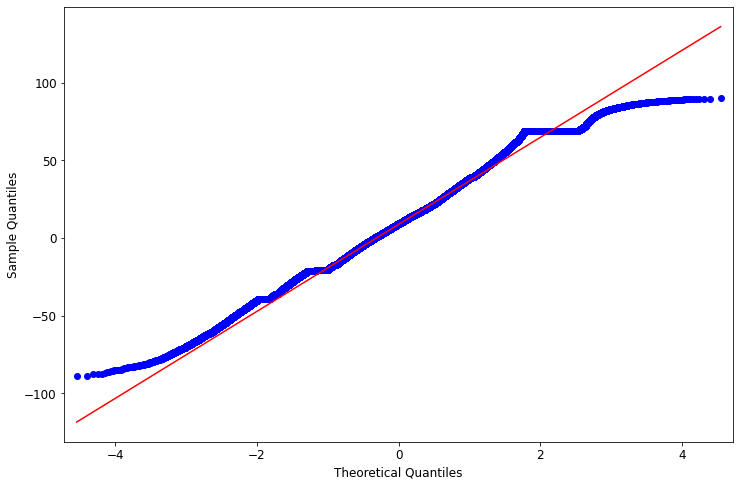

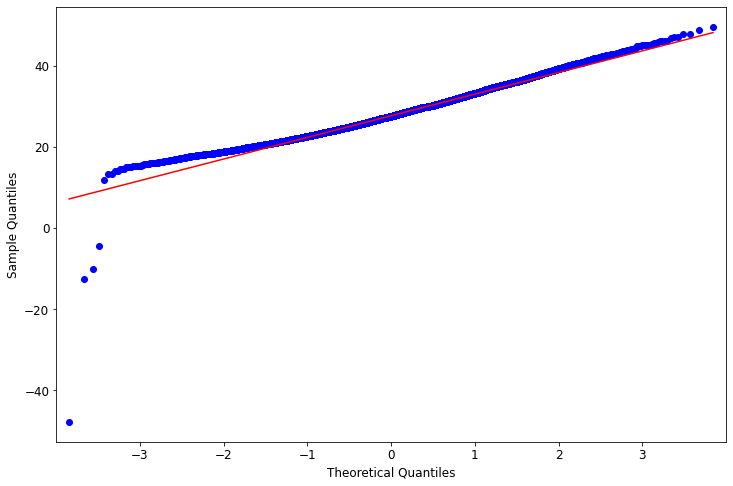

In [65]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution
# Note: dist: comparison distribution; the default is scipy.stats.distributions.norm (a standard normal)
#       line: options for the reference line to which the data is compared;
#             "45" - 45-degree line
#             "s" - standardized line, the expected order statistics are scaled by the standard deviation of the given sample and have the mean added to them
#             "r" - A regression line is fit
#             "q" - A line is fit through the quartile
all_MLB_teams2015_2017_new.groupby(by='hr').launch_angle.apply(lambda x: pd.Series(sm.qqplot(x, line='q')))
#plt.show()

In [66]:
# Perform the Shapiro-Wilk test for normality
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
# Note: p-value may not be accurate for N > 5000
sw_df = round(all_MLB_teams2015_2017_new.groupby(by='hr').launch_angle \
        .apply(lambda x: pd.Series(stats.shapiro(x.dropna()), index=['W-statistic', 'p-value'])), 3)
print('Shapiro-Wilk test:')
print('H0: the sample has a Normal distribution \nHa: the sample does not have a Normal distribution\n')
print(sw_df)

Shapiro-Wilk test:
H0: the sample has a Normal distribution 
Ha: the sample does not have a Normal distribution

hr             
0   W-statistic   0.992
    p-value         0.0
1   W-statistic   0.983
    p-value         0.0
Name: launch_angle, dtype: float64


/Users/yangweichle/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[Mann-Whitney U test](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

In [67]:
# Compute the Mann-Whitney rank test on samples x and y
# Use only when the number of observation in each sample is > 20 and you have 2 independent samples of ranks
# This test corrects for ties and by default uses a continuity correction
# Note: alternative: defines the alternative hypothesis;
#                    'two-sided', 'less': one-sided, 'greater': one-sided
statistic, pvalue = stats.mannwhitneyu(*all_MLB_teams2015_2017_new.groupby(by='hr').launch_angle.apply(lambda x: list(x)),
                                       alternative='two-sided')
print('Mann-Whitney U test:')
print('U-statistic =', round(statistic, 3))
print('p-value     =', round(pvalue, 3))

Mann-Whitney U test:
U-statistic = 1527992500.0
p-value     = 0.0


[Independent Two-Sample T-test](https://pythonfordatascience.org/independent-t-test-python/)

In [68]:
# Calculate the T-test for the means of *two independent* samples of scores
# Note: equal_var: if True (default), perform a standard independent 2 sample test that assumes equal population variances;
#                  if False, perform Welch's t-test, which does not assume equal population variance
#       nan_policy: defines how to handle when input contains nan. 'propagate' returns nan, 'raise' throws an error,
#                   'omit' performs the calculations ignoring nan values; default is 'propagate'
statistic, pvalue = stats.ttest_ind(*all_MLB_teams2015_2017_new.groupby(by='hr').launch_angle.apply(lambda x: list(x)),
                                    equal_var=True, nan_policy='omit')
print('Independent Two-Sample t-test:')
print('t-statistic =', round(statistic, 3))
print('p-value     =', round(pvalue, 3))

Independent Two-Sample t-test:
t-statistic = -84.535
p-value     = 0.0


In [69]:
a = all_MLB_teams2015_2017_new.groupby(by='hr').launch_angle.apply(lambda x: list(x))
a0 = pd.Series(a[0])
a1 = pd.Series(a[1])
descriptives, results = rp.ttest(a0, a1, 'No HR', 'HR')
round(descriptives, 3)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,No HR,"369,261.0",9.884,27.575,0.045,9.795,9.973
1,HR,"16,587.0",27.998,5.258,0.041,27.918,28.078
2,combined,"385,848.0",10.663,27.246,0.044,10.577,10.749


In [70]:
round(results, 3)

,Independent t-test,results
0,Difference (No HR - HR) =,-18.114
1,Degrees of freedom =,"385,846.0"
2,t =,-84.534
3,Two side test p value =,0.0
4,Difference < 0 p value =,0.0
5,Difference > 0 p value =,1.0
6,Cohen's d =,-0.671
7,Hedge's g =,-0.671
8,Glass's delta =,-0.657
9,r =,0.135


### Data Modeling

#### Predicting HRs

In [71]:
print('Percentage of HR=No(0), HR=Yes(1)')
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
value_counts_func(all_MLB_teams2015_2017_new, 'hr', bar=False)

Percentage of HR=No(0), HR=Yes(1)


hr,counts,percentage
0,369261,95.70
1,16587,4.30


### Note: CLASSES ARE HIGHLY IMBALANCED!!

### Using Random Forests for Classification

#### [2 Main Differences Between Classification and Regression Trees](http://www.simafore.com/blog/bid/62482/2-main-differences-between-classification-and-regression-trees)

#### Build and train random forest classification models

Note: <br>
- `RandomForestClassifier` does not support missing values for targets.
- Categorical predictor variables must be converted to numeric variables with integer values in order to use `RandomForestClassifier`.

In [72]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
null_counts = all_MLB_teams2015_2017_new.isnull().sum()
total_counts = all_MLB_teams2015_2017_new.isnull().count()
missing_percentage = round(null_counts/total_counts*100, 2)
missing_df = pd.DataFrame({'null_count': null_counts, 'percentage': missing_percentage})
missing_df[missing_df.null_count > 0]

,null_count,percentage
des,2,0.0
hit_distance_sc,45864,11.89


Create dummy variables for `pitch_name`.

In [73]:
# Convert categorical variable into dummy/indicator variables
# Note: prefix: string to append DataFrame column names
#       drop_first=True removes the first level to get k-1 dummies out of k categorical events
# Join columns with other DataFrame either on index or on a key
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.join(pd.get_dummies(all_MLB_teams2015_2017_new.pitch_name, prefix='pitch_name', drop_first=True))
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,...,xbh,pitch_name_4-Seam Fastball,pitch_name_Changeup,pitch_name_Curveball,pitch_name_Cutter,pitch_name_Knuckle Ball,pitch_name_Knuckle Curve,pitch_name_Sinker,pitch_name_Slider,pitch_name_Split Finger
2139914,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.6,"572,761.0",field_out,...,0,1,0,0,0,0,0,0,0,0
2139912,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FC,Cutter,89.9,"518,792.0",double,...,1,0,0,0,1,0,0,0,0,0
2139909,2015-04-05,CHC,STL,Jon Lester,"452,657.0",FF,4-Seam Fastball,93.2,"407,812.0",single,...,0,1,0,0,0,0,0,0,0,0
2139899,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,88.1,"451,594.0",double,...,1,0,0,0,1,0,0,0,0,0
2139895,2015-04-05,CHC,STL,Adam Wainwright,"425,794.0",FC,Cutter,89.9,"624,585.0",field_out,...,0,0,0,0,1,0,0,0,0,0


### Building Phase

In [74]:
# # Create a list of features
# feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle',
#                 'pitch_name_4-Seam Fastball', 'pitch_name_Changeup', 'pitch_name_Curveball', 'pitch_name_Cutter',
#                 'pitch_name_Knuckle Ball', 'pitch_name_Knuckle Curve', 'pitch_name_Sinker', 'pitch_name_Slider', 'pitch_name_Split Finger']

In [75]:
feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle', 'pitch_name']

In [76]:
# Create X and y
X = all_MLB_teams2015_2017_new[feature_cols]
y = all_MLB_teams2015_2017_new.hr

In [77]:
# Split X and y into random training and testing subsets
# --> Generate stratified train and test sets for classification
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
#       stratify: if not None, data is split in a stratified fashion, using this as the class labels
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=65, stratify=y)

print('Length of X_train: {}'.format(len(X_train)))
print('Length of y_train: {}'.format(len(y_train)))
print('Length of X_test: {}'.format(len(X_test)))
print('Length of y_test: {}'.format(len(y_test)))

Length of X_train: 270093
Length of y_train: 270093
Length of X_test: 115755
Length of y_test: 115755


#### Compute Baseline Accuracy
[How to Get Baseline Results and Why They Matter](https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/)

In [78]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
print(y_train.value_counts())
print()

most_freq_class = y_train.value_counts().index[0]
print('Most frequent class in training dataset:', most_freq_class)
print()

print('Baseline accuracy in test dataset:', round(y_test.value_counts()[most_freq_class] / y_test.count(), 3))
class_0_prob = y_test.value_counts()[0] / y_test.count()
class_1_prob = y_test.value_counts()[1] / y_test.count()

# Instantiate a classifier that makes predictions using simple rules and fit dummy classifier
# Note: stragegy: strategy to use to generate predictions
#       random_state: the seed used by the random number generator
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_clf.fit(X_train, y_train)
print('Baseline accuracy in test dataset:', round(dummy_clf.score(X_test, y_test), 3))

0    258482
1     11611
Name: hr, dtype: int64

Most frequent class in training dataset: 0

Baseline accuracy in test dataset: 0.957
Baseline accuracy in test dataset: 0.957


Note: Creating train/test as arrays for purpose of running code below: 'Understanding the decision tree structure'. DataFrames do not work for this code.

In [79]:
X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values

#### Incorporate oversampling with SMOTE, data preprocessing, and model training, into an imblearn pipeline
- In most cases, it's recommended to perform feature scaling after applying SMOTE when building a pipeline for imbalanced datasets. The reason for this order is that SMOTE generates synthetic samples to balance the class distribution, and these synthetic samples are typically created within the feature space of the original data. Therefore, it's a good practice to apply feature scaling after SMOTE to ensure that both the original and synthetic samples are scaled consistently, which can be important for some machine learning models.

The proper order of steps in the pipeline would be:

1. Apply SMOTE to balance the class distribution.
 - SMOTE:   for dataset containing continuous features only
 - SMOTEN:  for dataset containing categorical features only
 - SMOTENC: for dataset containing continuous and categorical features
2. Apply feature scaling, such as `StandardScaler`, to the combined dataset (original and synthetic samples).
3. Apply your machine learning algorithm, such as `LogisticRegression`, to the scaled data.

By following this order, you ensure that your data is properly prepared for modeling: first, address the class imbalance with SMOTE, then scale the data for improved model performance.

#### Over-sampling using Synthetic Minority Over-Sampling Technique (SMOTE)
- Works by creating synthetic samples from the minor class (HR=Yes) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [80]:
print('Before over-sampling, counts of label "0": {}'.format(sum(y_train==0)))
print('Before over-sampling, counts of label "1": {}'.format(sum(y_train==1)))

Before over-sampling, counts of label "0": 258482
Before over-sampling, counts of label "1": 11611


Note: Over-sampling only on the training data. By over-sampling on the training data only, none of the information in the test data is being used to create synthetic observations. Therefore, no information will bleed from test data into the model training.

#### _Data Preprocessing_
- **Scaling Numerical Features:** Scaling numerical features (e.g., using `StandardScaler`) is a standard preprocessing step to improve the training process for machine learning models. It is performed to ensure that all numerical features have similar scales. It helps the optimization process during training and prevents features with larger scales from dominating the learning process. However, this scaling process only affects the numerical features. It does not impact the coefficients of non-numerical (categorical) features. The coefficients for categorical features are determined based on the unique categories or levels of those features and remain unchanged by the scaling of numerical features.
- **Encoding Categorical Features:** Before using categorical features in a machine learning model, you typically need to encode them into a numeric format. Common encoding techniques include one-hot encoding (for nominal features) and ordinal encoding (for ordinal features). These encoding methods create binary or integer columns to represent the categories, and these encoded features do not require scaling.
- **One-Hot Encoding:**
    - It is common practice to drop one category per feature. This is known as creating dummy variables. The reason for dropping one category (often referred to as the "reference category") is to avoid multicollinearity, which can be an issue in certain models, especially linear models like linear regression and logistic regression. Multicollinearity occurs because one-hot encoded features are linearly dependent; the value of the dropped category can be inferred from the others.
    - If you are using tree-based models (like decision trees, random forests, gradient boosting machines), it is generally not necessary to drop a category when using one-hot encoding, as these models can handle multicollinearity better than linear models. However, with large numbers of categories, one-hot encoding can lead to a very high-dimensional feature space, which might be problematic from a computational standpoint. In such cases, other encoding methods might be more efficient.
    - For distance-based algorithms like kNN and SVM, dropping one category per categorical feature after one-hot encoding is not strictly necessary. It's more important to ensure that the encoding of features are appropriate for the algorithm and that the "curse of dimensionality", where the distance in high-dimensional space becomes less meaningful, is managed effectively.

Machine learning algorithms that rely on distance-based calculations or gradient-based optimization typically require numeric features to be scaled. Scaling ensures that all features have similar scales and magnitudes, which can improve the performance and convergence of these algorithms. Here are some machine learning algorithms that commonly benefit from feature scaling:

1. **K-Nearest Neighbors (KNN):** KNN calculates distances between data points to make predictions. Feature scaling is crucial because larger magnitude features can dominate the distance calculation.

2. **Support Vector Machines (SVM):** SVM aims to find a hyperplane that maximizes the margin between classes. Scaling helps ensure that the margin is not dominated by features with larger scales.

3. **Principal Component Analysis (PCA):** PCA is used for dimensionality reduction. Feature scaling is important because PCA is sensitive to the scales of features.

4. **Gradient-Based Algorithms (e.g., Gradient Descent):** Algorithms like linear regression, logistic regression, neural networks, and many others that use gradient-based optimization techniques benefit from scaled features. Scaling helps the optimization process converge faster and more reliably.

5. **Regularized Models (e.g., Lasso, Ridge, ElasticNet):** These models involve regularization terms that depend on the scale of the coefficients. Scaling features ensures that the regularization terms treat all features equally.

6. **K-Means Clustering:** K-Means calculates cluster centroids based on the mean of data points in each cluster. Scaling helps ensure that all features contribute equally to the cluster centroids.

7. **Hierarchical Clustering:** Similar to K-Means, hierarchical clustering methods can benefit from scaled features when calculating distances between clusters.

8. **Principal Component Regression (PCR):** PCR combines PCA with regression. Scaled features are essential for both PCA and regression components.

9. **Neural Networks:** Deep learning models, including neural networks, often require feature scaling, especially when using activation functions like sigmoid or tanh.

On the other hand, some algorithms are inherently scale-invariant, meaning they don't require feature scaling. These include:

1. **Decision Trees:** Decision trees and ensemble methods based on them (e.g., Random Forests, Gradient Boosting Trees) are not sensitive to feature scales.

2. **Naive Bayes:** Naive Bayes classifiers are not affected by feature scaling since they work with probability distributions.

3. **Tree-Based Models:** Models like decision trees, Random Forests, and XGBoost are invariant to feature scaling because they make decisions based on relative feature ordering.

4. **Rule-Based Models:** Models like association rule mining (e.g., Apriori) and rule-based classifiers (e.g., RIPPER) are not affected by feature scaling.

While scaling is crucial for some algorithms, it's a best practice to perform feature scaling for most machine learning tasks. Scikit-learn provides preprocessing tools like `StandardScaler` and `MinMaxScaler` to easily scale numeric features for various algorithms.

In [81]:
# Define numerical and categorical feature columns

# List of numeric feature column names
numeric_features = ['pitch_velocity', 'exit_velocity', 'launch_angle']

# List of categorical feature column names
categorical_features = ['pitch_name']

In [82]:
# Create preprocessing transformers for numeric and categorical features
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler()) # Scaling for numeric features
# ])

categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(drop='first')) # One-hot encoding for categorical features (linear models)
    ('onehot', OneHotEncoder())             # One-hot encoding for categorical features
])

# Applies transformers to columns of an array or pandas DataFrame
# -> This estimator allows different columns or column subsets of the input to be transformed separately 
#    and the features generated by each transformer will be concatenated to form a single feature space
# -> This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms 
#    or transformations into a single transformer
# Note: transformers: list of (name, transformer, column(s)) tuples specifying the transformer objects 
#                     to be applied to subsets of the data
#       remainder: {'drop', 'passthrough'} or estimator, default 'drop'
#                  By default, only the specified columns in `transformers` are transformed and combined 
#                  in the output, and the non-specified columns are dropped. (default of ``'drop'``).
#                  By specifying remainder='passthrough', all remaining columns that were not specified 
#                  in `transformers` will be automatically passed through. 
#                  This subset of columns is concatenated with the output of the transformers.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features), # Scaling not necessary for tree-based models
        ('cat', categorical_transformer, categorical_features)
    ],
#     remainder='passthrough'
)
preprocessor

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['pitch_velocity', 'exit_velocity',
                                  'launch_angle']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['pitch_name'])])

In [83]:
# Instantiate a random forest classifier
# Note: n_estimators: number of trees in the forest
#       criterion: function to measure the quality of a split; supported criteria are "gini" for the Gini impurity 
#                  and "entropy" for the information gain
#       max_depth: maximum depth of the tree; if None, then nodes are expanded until all leaves are pure or 
#                  until all leaves contain less than min_samples_split samples
#       random_state: the seed used by the random number generator
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, random_state=46)

#### [Calibrate Probabilities of Classification Model](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)

Several machine learning models produce predicted probabilities that are often uncalibrated, meaning they do not provide reliable probability estimates that correspond to the true likelihood of an event occurring. These uncalibrated models may benefit from calibration techniques to improve the accuracy of their predicted probabilities. Some common models that often produce uncalibrated probabilities include:

1. **Support Vector Machines (SVM):** SVMs are primarily designed for classification tasks and do not inherently provide well-calibrated probability estimates. The predicted scores from an SVM may not align well with actual probabilities.

2. **Random Forests:** While Random Forests are robust and powerful classifiers, they are known for producing biased probability estimates. They tend to be overconfident and may assign high probabilities to predictions, even when they are uncertain.

3. **Gradient Boosting (e.g., XGBoost, LightGBM):** Gradient boosting models, while highly accurate for classification tasks, often require post-processing calibration to obtain well-calibrated probability estimates.

4. **Neural Networks (Deep Learning):** Deep neural networks can produce poorly calibrated probability estimates, particularly when the model is overfitting or underfitting the data.

5. **K-Nearest Neighbors (KNN):** KNN, a non-parametric method, does not inherently provide probability estimates. However, you can assign probabilities based on the fraction of neighbors belonging to each class, which may require calibration.

6. **Naive Bayes:** Despite its name, Naive Bayes can produce poorly calibrated probabilities, especially when its "naive" assumption of feature independence is violated.

7. **Decision Trees:** Decision trees, when used for classification, tend to produce biased probability estimates. Ensemble methods like Random Forests, which use multiple decision trees, may also inherit this issue.

**Create a calibrated classifier using CalibratedClassifierCV**

Including `StratifiedKFold` in the `cv` parameter of `CalibratedClassifierCV` ensures that the calibration process is performed within a stratified cross-validation framework. This can help improve the robustness of probability calibration, especially in imbalanced class scenarios.

In [84]:
# Probability calibration with isotonic regression or sigmoid
# Note: base_estimator: the classifier whose output decision function needs to be calibrated to 
#                       offer more accurate predict_proba outputs
#       method: method to use for calibration; 'sigmoid' or 'isotonic'; 'sigmoid' corresponds to Platt's method;
#               'isotonic' is a non-parametric approach; not advised to use isotonic with too few calibration samples
#       cv: determines the cross-validation splitting strategy
#       ensemble: Determines how the calibrator is fitted when cv is not 'prefit'; ignored if cv='prefit'
#                 If `True`, the `base_estimator` is fitted using training data and calibrated using testing 
#                   data, for each `cv` fold. The final estimator is an ensemble of `n_cv` fitted classifier 
#                   and calibrator pairs, where `n_cv` is the number of cross-validation folds. The output is 
#                   the average predicted probabilities of all pairs.
#                 If `False`, `cv` is used to compute unbiased predictions, via `cross_val_predict`, which are 
#                   then used for calibration. At prediction time, the classifier used is the `base_estimator`
#                   trained on all the data.
calibrated_rf_clf = CalibratedClassifierCV(base_estimator=rf_clf, method='sigmoid',
                                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=11),
                                           ensemble=False)

In [85]:
pipeline = ImbPipeline(
    steps=[
        # Class to perform over-sampling using SMOTENC
        # -> Implementation of SMOTENC - Synthetic Minority Over-sampling Technique for Nominal and Continuous
        # Note: categorical_features: specified which features are categorical
        #       sampling_strategy: sampling information to resample the data set
        #       random_state: the seed used by the random number generator
        ('smotenc', SMOTENC(categorical_features=[3], sampling_strategy='auto', random_state=42)), # Resample using SMOTENC to balance classes
        ('preprocessor', preprocessor), # Apply preprocessing to features
        ('classifier', calibrated_rf_clf) # Classifier
])
pipeline

Pipeline(steps=[('smotenc', SMOTENC(categorical_features=[3], random_state=42)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['pitch_name'])])),
                ('classifier',
                 CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=3,
                                                                              random_state=46),
                                        cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
                                        ensemble=False))])

In [86]:
# Fit the model
# -> Fit all the transforms one after the other and transform the data,
#    then fit the transformed data using the final estimator
pipeline.fit(X_train, y_train) # Training the model

Pipeline(steps=[('smotenc', SMOTENC(categorical_features=[3], random_state=42)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['pitch_velocity',
                                                   'exit_velocity',
                                                   'launch_angle']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['pitch_name'])])),
                ('classifier',
                 CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=3,
                                                                              random_state=46),
                                        cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
                                        ensemble=False))])

In [87]:
# Access the SMOTENC object from the pipeline
smotenc_transformer = pipeline.named_steps['smotenc']

# Use the fit_resample method to get resampled data
X_train_res, y_train_res = smotenc_transformer.fit_resample(X_train, y_train)

print('After over-sampling, the length of resampled_X: {}'.format(len(X_train_res)))
print('After over-sampling, the length of resampled_y: {} \n'.format(len(y_train_res)))

# Calculate class counts
class_counts = dict(zip(*np.unique(y_train_res, return_counts=True)))

# Print the class counts after resampling
print(class_counts)
print('After over-sampling, counts of label "0": {}'.format(sum(y_train_res==0)))
print('After over-sampling, counts of label "1": {}'.format(sum(y_train_res==1)))

After over-sampling, the length of resampled_X: 516964
After over-sampling, the length of resampled_y: 516964 

{0: 258482, 1: 258482}
After over-sampling, counts of label "0": 258482
After over-sampling, counts of label "1": 258482


In [88]:
print('Proportion of label "0" in over-sampled data', sum(y_train_res==0)/len(X_train_res))
print('Proportion of label "1" in over-sampled data', sum(y_train_res==1)/len(X_train_res))

Proportion of label "0" in over-sampled data 0.5
Proportion of label "1" in over-sampled data 0.5


Note: CLASSES ARE PERFECTLY BALANCED!!

In [89]:
# Predict the class labels using the random forest model and trained pipeline
y_pred_class_rf_clf = pipeline.predict(X_test)

In [90]:
# Calculate predicted probability estimates of class membership
# Each row sums to one and contains the probabilities of class=0 and class=1
pipeline.predict_proba(X_test)[0:10]

array([[0.05499092, 0.94500908],
       [0.97194289, 0.02805711],
       [0.9793807 , 0.0206193 ],
       [0.99667208, 0.00332792],
       [0.9965242 , 0.0034758 ],
       [0.97237934, 0.02762066],
       [0.7829799 , 0.2170201 ],
       [0.97801309, 0.02198691],
       [0.97710899, 0.02289101],
       [0.96201694, 0.03798306]])

In [91]:
# Calculate predicted probability estimates
y_pred_prob_rf_clf = pipeline.predict_proba(X_test)[:, 1]

### Operational Phase

[Classification Accuracy is Not Enough: More Performance Measures You Can Use](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)

### $\text{Precision = Positive Predictive Value (PPV)} = {TP \over (TP \ + \ FP)} = {TP \over (Total \ Predicted \ Positive)} --> \text{completeness}$
- "How many of the items selected are relevant"
- Of the items placed into a class, how many of them are True Positives.
- The ability of the classifier to not label a sample as positive if it is negative.

### $\text{Recall = True Positive Rate (Sensitivity)} = {TP \over (TP \ + \ FN)} = {TP \over (Total \ Actual \ Positive)} --> \text{exactness}$
- "How many of the relevant items are selected"
- Of the items that were suppose to be placed into a class, how many did we accurately place.
- The ability of the classifier to find all the positive samples.

### $F_{1}Score = 2*\frac{\text{Precision * Recall}}{\text{Precision + Recall}}$
- 0 <= F1 <= 1, where 0 is awful and 1 is perfection.
- F1 is considered a harmonic mean as it averages Precision and Recall.
- With classification models you often times have to choose what kind of error you are willing to increase in order to reduce the other and thus you may want to optimize Precision or Recall accordingly.
- If you are uncertain which you should optimize, F1 score may be the metric of choice.

In [92]:
# Function to make predictions 
def prediction(X_test, clf_object, model_type_text): 
  
    # Predict the class labels using the classifier model
    y_pred_class = clf_object.predict(X_test)
    
    # Calculate predicted probability estimates of each class
    y_pred_prob = clf_object.predict_proba(X_test)[:, 1]

    print('Results Using {}:'.format(model_type_text))
    print('Predicted values:')
    print(y_pred_class)
    print('')
    return y_pred_class, y_pred_prob

Note: Function uses resampled training data (`X_train_res`, `y_train_res`) to calculate training accuracy

In [93]:
# Function to calculate evaluation metrics
def eval_metrics(y_test, y_pred_class, y_pred_prob, clf_object):
      
    # Training accuracy classification score
    training_acc_score = metrics.accuracy_score(y_train_res, clf_object.predict(X_train_res))
    print('Training accuracy score:', round(training_acc_score, 4))
    
    # Testing accuracy classification score
    testing_acc_score = metrics.accuracy_score(y_test, y_pred_class)
    print('Testing accuracy score :', round(testing_acc_score, 4))
    
    if testing_acc_score > training_acc_score:
        print('Testing accuracy > Training accuracy')
        print('-> Not overfitting')
    else:
        print('Testing accuracy < Training accuracy')
        print('-> Overfitting!')
    print('')
    
    # Confusion matrix to evaluate the accuracy of a classification
    print('Confusion Matrix:')
    conmat = metrics.confusion_matrix(y_test, y_pred_class)
    
    # Return a flattened array
    tn, fp, fn, tp = conmat.ravel()
    
    print(pd.DataFrame(conmat,
                       index=['True No HR', 'True HR'],
                       columns=['Pred No HR', 'Pred HR']))
    
    print('\nPerformance Measures:')
    cm = [['TN  ',   'FP  ', 'TN + FP'], 
          ['FN  ',   'TP  ', 'FN + TP'],
          ['TN + FN', 'FP + TP', '']]
    print(pd.DataFrame(cm,
                       index=  ['True (0) ', 'True (1) ', 'Total '],
                       columns=['Pred (0)', 'Pred (1)', 'Total']))
    
    print('')
    print('Sensitivity (Recall)                        = TP/(TP + FN) =', round(tp/(tp + fn), 4))
    print('Specificity                                 = TN/(FP + TN) =', round(tn/(fp + tn), 4))
    print('Precision (Positive Predictive Value (PPV)) = TP/(TP + FP) =', round(tp/(tp + fp), 4))
    print('Negative Predictive Value (NPV))            = TN/(FN + TN) =', round(tn/(fn + tn), 4))
    print('F1 Score                                    = 2*(Precision*Recall)/(Precision + Recall) =', round(2*(tp)/(2*(tp) + fp + fn), 4))
    print('\nAccuracy = (TP + TN)/(TP + TN + FP + FN) =', round((tp + tn)/(tp + tn + fp + fn), 4))
    
    # Build a text report showing the main classification metrics
    print('\nClassification Report:')
    print(metrics.classification_report(y_test, y_pred_class))
    print('')
    
    # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    print('ROC AUC:', round(roc_auc, 3))
    print('')
    
    # Compute Precision-Recall (PR) Curve
    # Note: This implementation is restricted to the binary classification task
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_prob)
    
    # Compute Precision-Recall (PR) Area Under the Curve (AUC) Score
    auc = metrics.auc(x=recall, y=precision)
    print('PR AUC:', round(auc, 3))
    print('The focus on the positive (minority) class makes the Precision-Recall AUC more useful for imbalanced classification')
    print('')
    print('')
    
    print('Evaluation Metrics to Compare Models that Predict Probabilities')
    print('---------------------------------------------------------------')
    print('')
    
    # Log loss, aka logistic loss or cross-entropy loss
    print('Log Loss:')
    # Using baseline probabilities for both classes
    baseline_probs = [[class_0_prob, class_1_prob] for _ in range(len(y_test))]
    avg_logloss_baseline = metrics.log_loss(y_test, baseline_probs)
    print('Baseline = %.3f' % (avg_logloss_baseline))

    # Using model predicted probabilities of the positive class
    avg_logloss_model = metrics.log_loss(y_test, y_pred_prob)
    print('Model    =', round(avg_logloss_model, 3))
    print('')
    
    # Brier Score
    print('Brier Score:')
    print(' -> Focused on the positive class, which for imbalanced classification is the minority class')
    # Using baseline probabilities for the positive class
    baseline_probs_pos_class = [col[1] for col in baseline_probs]
    avg_brier_score_baseline = metrics.brier_score_loss(y_test, baseline_probs_pos_class)
    print('Baseline = %.3f' % (avg_brier_score_baseline))

    # Using model predicted probabilities of the positive class
    avg_brier_score_model = metrics.brier_score_loss(y_test, y_pred_prob)
    print('Model    =', round(avg_brier_score_model, 3))
    
    # Brier Skill Score (BSS)
    # BSS = 1 - (BS_mod / BS_ref)
    bss = 1 - (avg_brier_score_model / avg_brier_score_baseline)
    print('Brier Skill Score =', round(bss, 3))

#### Interpret the Prediction of Probabilities for Binary Classification Models
[ROC Curves and Precision-Recall Curves for Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

- **ROC Curves** are appropriate when the *observations are balanced between each class*, whereas **Precision-Recall Curves** are appropriate for *imbalanced datasets*
    - ROC Curves should be used when there are roughly equal numbers of observations for each class
    - Precision-Recall Curves should be used when there is a moderate to large class imbalance


- **ROC Curves** summarize the trade-off between the **True Positive Rate (Sensitivity)** and **False Positive Rate (1-Specificity)** for a predictive model using different probability thresholds
    - True Positive Rate (Sensitivity) summarizes how often a positive class is predicted when the actual outcome is positive
    - False Positive Rate (1-Specificity) is also called the *false alarm rate* as it summarizes how often a positive class is predicted when the actual outcome is negative


- **Precision-Recall Curves** summarize the trade-off between the **True Positive Rate (Recall)** and the **Positive Predictive Value (Precision)** for a predictive model using different probability thresholds
    - Precision (PPV) describes how good a model is at predicting the positive class; intuitively the ability of the classifier not to label as positive a sample that is negative
    - Recall (Sensitivity) summarizes how often a positive class is predicted when the actual outcome is positive; intuitively the ability of the classifier to find all the positive samples
        - Reviewing both Precision and Recall is useful in cases where there is an imbalance in the observations between the two classes
        - Typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high True Negatives
        - Key to the calculation of Precision and Recall is that the calculations do not make use of the True Negatives -- it is only concerned with the correct prediction of the minority class, class 1

[Optimal Threshold for ROC Curve and Precision-Recall Curve](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

In [94]:
def plot_roc_curve(y_test, y_pred_prob):

    # Compute Receiver Operating Characteristic (ROC) Curve
    # Note: This implementation is restricted to the binary classification task
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

    # Find optimal threshold based on maximizing the Geometric Mean
    # If optimized, it will seek a balance between Sensitivity and Specificity
    # Calculate the Geometric Mean for each threshold: G-Mean = sqrt(Sensitivity * Specificity)
    # Note: Sensitivity = TPR; Specificity = 1 - FPR
    gmeans = np.sqrt(tpr * (1-fpr))
    # Locate the index of the largest G-Mean
    ix = np.argmax(gmeans)
    # Identify the optimal threshold based on index of the largest G-Mean
    optimal_threshold = thresholds[ix]
    max_gmean = gmeans[ix]
    print('Optimal Threshold: {0:0.2f}'.format(optimal_threshold) + ', G-Mean: {0:0.3f}'.format(max_gmean))
    
    # Find optimal threshold based on maximizing the Youden's J statistic
    # Calculate the J statistic for each threshold: J = TPR – FPR
    J = tpr - fpr
    # Locate the index of the largest J statistic
    ix = np.argmax(J)
    # Identify the optimal threshold based on index of the largest J statistic
    optimal_threshold = thresholds[ix]
    max_j = J[ix]
    print('Optimal Threshold: {0:0.2f}'.format(optimal_threshold) + ', J statistic: {0:0.3f}'.format(max_j))
    
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) Score
    # Note: This implementation can be used with binary, multiclass and multilabel classification, 
    #       but some restrictions apply
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)

    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr, tpr, label='ROC AUC = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--', label='No Skill')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Optimal')
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()

In [95]:
def plot_precision_recall_curve(y_test, y_pred_prob, y_pred_class):
    
    # Compute Precision-Recall (PR) Curve
    # Note: This implementation is restricted to the binary classification task
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)

    # Find optimal threshold based on maximizing the F-measure (F1-score)
    # If optimized, it will seek a balance between Precision and Recall
    # Calculate the F-score for each threshold: F-score = (2 * Precision * Recall) / (Precision + Recall)
    #f1_scores = (2 * precision * recall) / (precision + recall)
    f1_scores = [metrics.f1_score(y_test, (y_pred_prob >= threshold).astype('int')) for threshold in thresholds]
    # Locate the index of the largest F1-score
    ix = np.argmax(f1_scores)
    # Identify the optimal threshold based on index of the largest F1-score
    optimal_threshold = thresholds[ix]
    max_f1_score = f1_scores[ix]
    print('Optimal Threshold: {0:0.2f}'.format(optimal_threshold) + ', F1-score: {0:0.3f}'.format(max_f1_score))
    
    # Compute Precision-Recall (PR) Area Under the Curve (AUC) Score
    auc = metrics.auc(x=recall, y=precision)

    # Compute the Average Precision (AP) Score
    average_precision = metrics.average_precision_score(y_test, y_pred_prob)
    print('Average Precision (AP) Score: {0:0.3f}'.format(average_precision))

    # Compute the F1 Score, also known as balanced F-score or F-measure
    f1_score = metrics.f1_score(y_test, y_pred_class)
    print('F1 Score: {0:0.3f}'.format(f1_score))

    plt.title('2-class Precision-Recall (PR) Curve')
    plt.plot(recall, precision, label='PR AUC = {0:0.3f}'.format(auc))
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Optimal')
    no_skill = len(y_test[y_test==1]) / len(y_test) # ratio of positive cases in the dataset
    plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
    plt.legend()
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.show()   

#### Prediction using Random Forest Model

In [96]:
model_type_text='Random Forest Model'
y_pred_class_calibrated_rf_clf, y_pred_prob_calibrated_rf_clf = prediction(X_test, pipeline, model_type_text)
eval_metrics(y_test, y_pred_class_calibrated_rf_clf, y_pred_prob_calibrated_rf_clf, pipeline)

Results Using Random Forest Model:
Predicted values:
[1 0 0 ... 1 1 0]

Training accuracy score: 0.9379
Testing accuracy score : 0.93
Testing accuracy < Training accuracy
-> Overfitting!

Confusion Matrix:
            Pred No HR  Pred HR
True No HR      102977     7802
True HR            298     4678

Performance Measures:
          Pred (0) Pred (1)    Total
True (0)      TN       FP    TN + FP
True (1)      FN       TP    FN + TP
Total      TN + FN  FP + TP         

Sensitivity (Recall)                        = TP/(TP + FN) = 0.9401
Specificity                                 = TN/(FP + TN) = 0.9296
Precision (Positive Predictive Value (PPV)) = TP/(TP + FP) = 0.3748
Negative Predictive Value (NPV))            = TN/(FN + TN) = 0.9971
F1 Score                                    = 2*(Precision*Recall)/(Precision + Recall) = 0.536

Accuracy = (TP + TN)/(TP + TN + FP + FN) = 0.93

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0

#### Optimize model using grid-search with cross-validation

When dealing with an imbalanced dataset, it's often a good practice to use stratified k-fold cross-validation instead of regular k-fold cross-validation. Stratified k-fold ensures that each fold of the cross-validation maintains the same class distribution as the original dataset, which is crucial for training and evaluating models on imbalanced data.

Stratified k-fold cross-validation helps in the following ways:

- **Balanced Folds:** It ensures that each fold contains a representative proportion of each class, which helps in training and validating the model on both minority and majority classes.
- **Robust Evaluation:** It provides a more robust evaluation of the model's performance, especially when class imbalance is severe. Regular k-fold cross-validation can result in some folds with very few or no instances of the minority class, leading to unreliable performance estimates.

In [97]:
# Stratified K-Fold cross-validator
# Provides train/test indices to split data in train/test sets
# This cross-validation object is a variation of KFold that returns stratified folds
# The folds are made by preserving the percentage of samples for each class
# Note: n_splits: number of folds; must be at least 2 (default=5)
#       shuffle: whether to shuffle each class's samples before splitting into batches
#       random_state: random_state is the seed used by the random number generator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

In [98]:
# Define the parameter grid for hyperparameter tuning
parameters = {'classifier__base_estimator__n_estimators': [30, 50, 100],
              'classifier__base_estimator__criterion': ['gini', 'entropy'],
              'classifier__base_estimator__max_depth': [2, 3, 4]}

pprint(parameters)

{'classifier__base_estimator__criterion': ['gini', 'entropy'],
 'classifier__base_estimator__max_depth': [2, 3, 4],
 'classifier__base_estimator__n_estimators': [30, 50, 100]}


By using `StratifiedKFold` in the `cv` parameter of `GridSearchCV`, you ensure that the cross-validation process is stratified and addresses the challenges posed by class imbalance during hyperparameter tuning.

In [99]:
# Instantiate an exhaustive search over specified parameter values for an estimator and run fit with all sets of parameters
# Note: estimator: estimator object
#       param_grid: dictionary with parameters names (string) as keys and lists of parameter settings to try as values; 
#                   this enables searching over any sequence of parameter settings
#       scoring: a single string or a callable to evaluate the predictions on the test set
#       n_jobs: number of jobs to run in parallel; if -1, then the number of jobs is set to the number of cores
#       cv: number of folds in k-fold cross-validation
#       return_train_score: if False, the cv_results_ attribute will not include training scores
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='f1',
                           n_jobs=-1, cv=stratified_kfold, return_train_score=True)
search_time_start = time.time()
grid_search.fit(X_train, y_train)
print('Grid search time:', int((time.time() - search_time_start)/60), 'mins')

Grid search time: 24 mins


In [100]:
results = pd.DataFrame.from_dict(grid_search.cv_results_)
pd.DataFrame.from_dict(grid_search.cv_results_, orient='index').style.set_sticky(axis='index')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,148.430301,185.533489,246.935039,116.627009,149.089073,265.271126,113.552779,166.605015,316.799373,80.612226,113.990408,200.259149,96.165380,138.924324,263.985353,114.524692,160.148691,193.979845
std_fit_time,1.312374,2.238950,33.024756,0.862165,7.414512,2.003266,2.601461,0.771119,1.300962,1.038927,0.371396,2.947478,3.106715,1.581465,1.981025,1.789853,10.927729,15.064375
mean_score_time,0.337143,0.647521,0.762865,0.348311,0.497138,0.876640,0.356385,0.494571,0.831044,0.351670,0.475126,0.738953,0.306372,0.432832,0.762707,0.332311,0.374299,0.360998
std_score_time,0.034239,0.042726,0.022482,0.014159,0.041380,0.011657,0.011453,0.009558,0.058994,0.014302,0.040180,0.037315,0.019600,0.026975,0.085410,0.013441,0.084795,0.058012
param_classifier__base_estimator__criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_classifier__base_estimator__max_depth,2,2,2,3,3,3,4,4,4,2,2,2,3,3,3,4,4,4
param_classifier__base_estimator__n_estimators,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100,30,50,100
params,"{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 30}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 50}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 100}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__n_estimators': 30}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__n_estimators': 50}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__n_estimators': 100}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 4, 'classifier__base_estimator__n_estimators': 30}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 4, 'classifier__base_estimator__n_estimators': 50}","{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 4, 'classifier__base_estimator__n_estimators': 100}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 30}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 50}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 100}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__n_estimators': 30}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__n_estimators': 50}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__n_estimators': 100}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 4, 'classifier__base_estimator__n_estimators': 30}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 4, 'classifier__base_estimator__n_estimators': 50}","{'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 4, 'classifier__base_estimator__n_estimators': 100}"
split0_test_score,0.528632,0.529211,0.530503,0.529534,0.529598,0.531571,0.530503,0.528183,0.526823,0.488590,0.489724,0.487891,0.495805,0.494977,0.494480,0.497810,0.499437,0.499155
split1_test_score,0.526329,0.529116,0.529232,0.52936

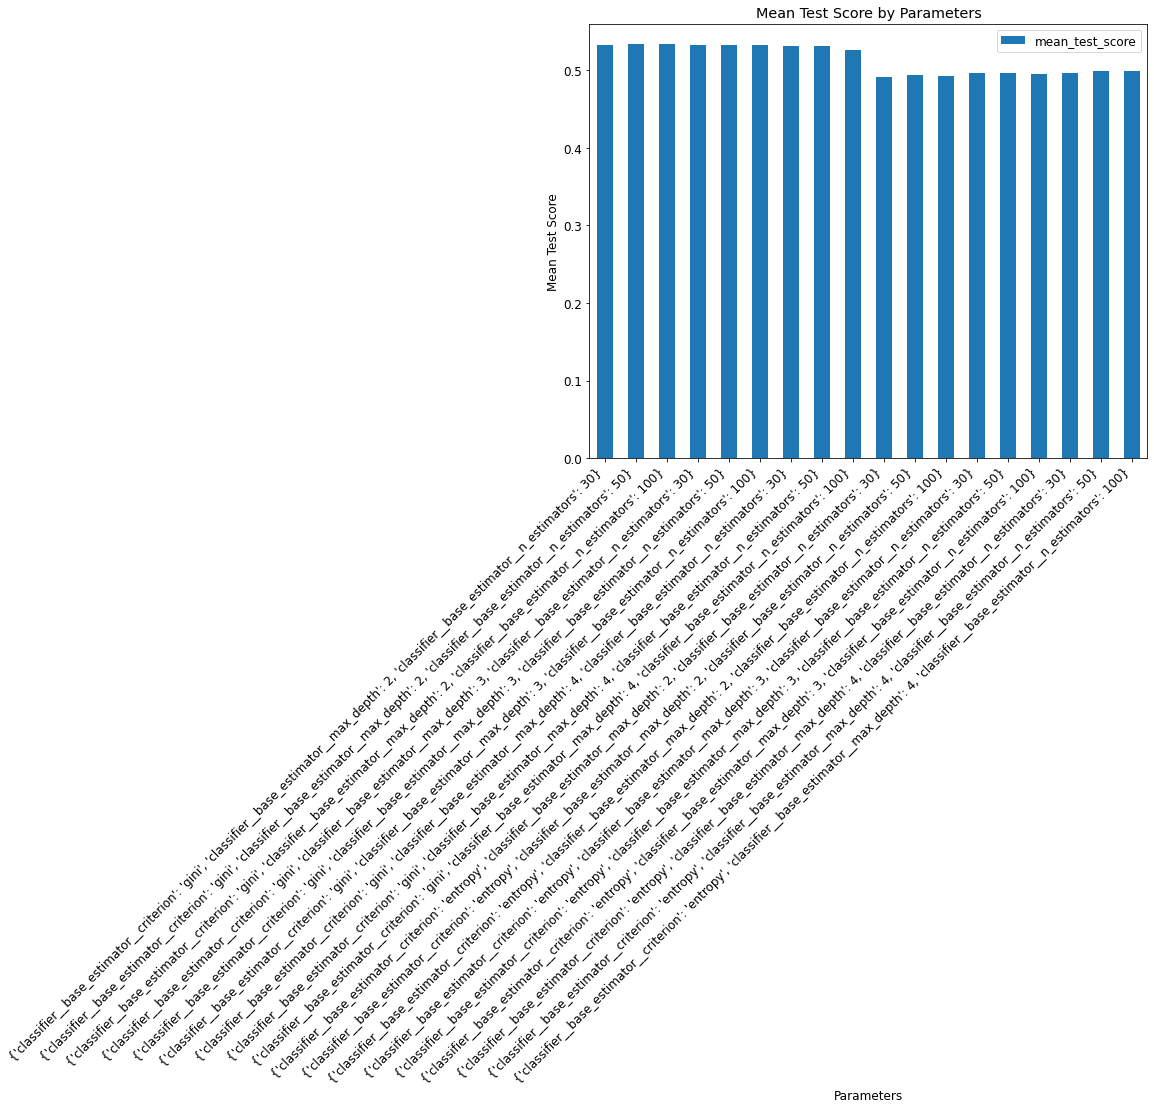

In [101]:
# Create a vertical bar plot by mean test score using matplotlib
# Note: figsize: a tuple (width, height) in inches
ax = results.plot.bar(y='mean_test_score', x='params', figsize=(10, 8));
ax.set_xticklabels(results.params, rotation=45, horizontalalignment='right');
plt.xlabel('Parameters');
plt.ylabel('Mean Test Score');
plt.title('Mean Test Score by Parameters');

In [102]:
print('Best parameter setting found by grid search:')
print(grid_search.best_params_)
print()
print('Best mean cross-validated score found by grid search:')
print(round(grid_search.best_score_, 3))
print()
print('Scorer function used on the held out data to choose the best parameters for the model:')
print(grid_search.scorer_)

Best parameter setting found by grid search:
{'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 50}

Best mean cross-validated score found by grid search:
0.533

Scorer function used on the held out data to choose the best parameters for the model:
make_scorer(f1_score, average=binary)


#### Prediction using Random Forest Model and Cross-Validation

In [103]:
model_type_text='Random Forest Model and Cross-Validation'
y_pred_class_grid_search, y_pred_prob_grid_search = prediction(X_test, grid_search.best_estimator_, model_type_text)
eval_metrics(y_test, y_pred_class_grid_search, y_pred_prob_grid_search, grid_search.best_estimator_)

Results Using Random Forest Model and Cross-Validation:
Predicted values:
[1 0 0 ... 1 1 0]

Training accuracy score: 0.9359
Testing accuracy score : 0.9308
Testing accuracy < Training accuracy
-> Overfitting!

Confusion Matrix:
            Pred No HR  Pred HR
True No HR      103083     7696
True HR            318     4658

Performance Measures:
          Pred (0) Pred (1)    Total
True (0)      TN       FP    TN + FP
True (1)      FN       TP    FN + TP
Total      TN + FN  FP + TP         

Sensitivity (Recall)                        = TP/(TP + FN) = 0.9361
Specificity                                 = TN/(FP + TN) = 0.9305
Precision (Positive Predictive Value (PPV)) = TP/(TP + FP) = 0.377
Negative Predictive Value (NPV))            = TN/(FN + TN) = 0.9969
F1 Score                                    = 2*(Precision*Recall)/(Precision + Recall) = 0.5376

Accuracy = (TP + TN)/(TP + TN + FP + FN) = 0.9308

Classification Report:
              precision    recall  f1-score   support

     

#### Plot Receiver Operating Characteristic (ROC) Curve
- The curves of different models can be compared directly in general or for different thresholds
- The area under the curve (AUC) can be used as a summary of the model skill
- Smaller values on the x-axis of the plot indicate lower False Positives and higher True Negatives
- Larger values on the y-axis of the plot indicate higher True Positives and lower False Negatives


- A model with perfect skill is depicted at a point at (0,1)
- A model with perfect skill is represented by a line that travels from the bottom left of the plot to the top left and then across the top to the top right

Optimal Threshold: 0.19, G-Mean: 0.937
Optimal Threshold: 0.19, J statistic: 0.874


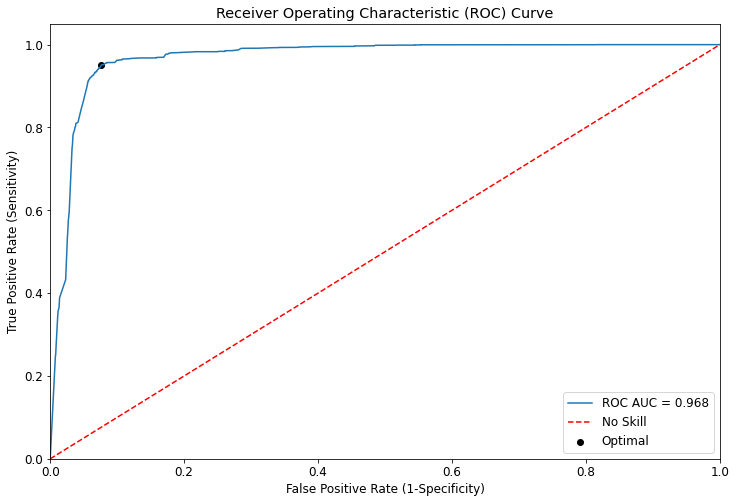

In [104]:
plot_roc_curve(y_test, y_pred_prob_grid_search)

#### Plot Precision-Recall Curve
- A model with perfect skill is depicted as a point at (1, 1)
- A skillful model is represented by a curve that bows towards (1, 1) above the flat line of no skill

Optimal Threshold: 0.93, F1-score: 0.616
Average Precision (AP) Score: 0.504
F1 Score: 0.538


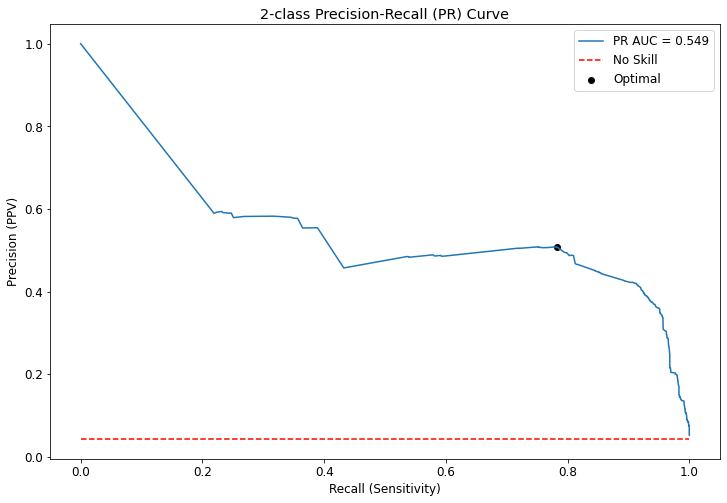

Plot PR Curve time: 0 mins


In [105]:
search_time_start = time.time()
plot_precision_recall_curve(y_test, y_pred_prob_grid_search, y_pred_class_grid_search)
print('Plot PR Curve time:', int((time.time() - search_time_start)/60), 'mins')